# Data Augmentation for wearable sensor data (Time Series)
공부해보니 time seies data 중에서도 wearable sensor data를 위한 data augmentation이 있다고 한다. 모든 내용은 테리(terryum)라는 유저의 깃허브인 (https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb) 에서 가져왔다.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from scipy.interpolate import CubicSpline      # for warping
from transforms3d.axangles import axangle2mat  # for rotation

In [3]:
# 데이터 불러오기

path = './data/'
train = pd.read_csv(path + 'train_features.csv')
train

,id,time,acc_x,acc_y,acc_z,gy_x,gy_y,gy_z
0,0,0,1.206087,-0.179371,-0.148447,-0.591608,-30.549010,-31.676112
1,0,1,1.287696,-0.198974,-0.182444,0.303100,-39.139103,-24.927216
2,0,2,1.304609,-0.195114,-0.253382,-3.617278,-44.122565,-25.019629
3,0,3,1.293095,-0.230366,-0.215210,2.712986,-53.597843,-27.454013
4,0,4,1.300887,-0.187757,-0.222523,4.286707,-57.906561,-27.961234
...,...,...,...,...,...,...,...,...
1874995,3124,595,-0.712530,-0.658357,0.293707,-29.367857,-104.013664,-76.290437
1874996,3124,596,-0.683037,-0.658466,0.329223,-30.149089,-101.796809,-76.625087
1874997,3124,597,-0.664730,-0.666625,0.364114,-27.873095,-98.776072,-79.365125
1874998,3124,598,-0.630534,-0.682565,0.373696,-23.636550,-99.139495,-80.259478


In [7]:
# 데이터 시각화를 위해 ID별로 묶는다.

data = tf.reshape(np.array(train.iloc[:,2:]),[-1, 600, 6])
data.shape

TensorShape([3125, 600, 6])

Text(0.5, 1.0, 'An example of data')

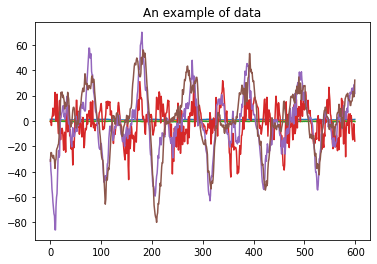

In [12]:
# 시각화를 해보자.
plt.plot(data[0,:,:])
plt.title("An example of data")

## 1. Jittering
Hyperparameters : sigma = standard devitation (STD) of the noise  

하이퍼 파라미터 : 시그마 = 노이즈의 표준 devitation (STD)

In [13]:
sigma = 0.05

In [14]:
def DA_Jitter(X, sigma=0.05):
    myNoise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X+myNoise

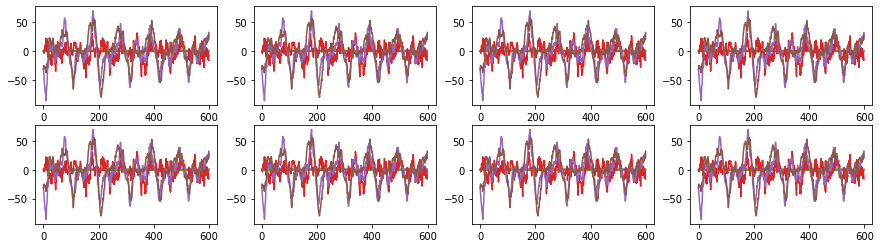

In [15]:

fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Jitter(data[0,:,:], sigma))

## 2. Scaling
Hyperparameters : sigma = STD of the zoom-in/out factor  

하이퍼 파라미터 : 시그마 = 확대/축소 계수의 STD

In [17]:
sigma = 0.1

In [18]:
def DA_Scaling(X, sigma=0.1):
    scalingFactor = np.random.normal(loc=1.0, scale=sigma, size=(1,X.shape[1])) # shape=(1,3)
    myNoise = np.matmul(np.ones((X.shape[0],1)), scalingFactor)
    return X*myNoise

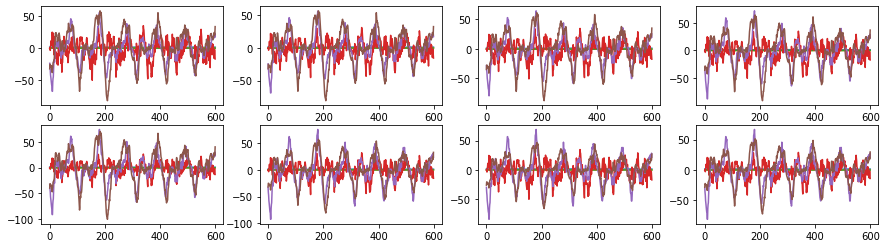

In [19]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Scaling(data[0,:,:], sigma))

## 3. Magnitude Warping
Hyperparameters : sigma = STD of the random knots for generating curves  
knot = # of knots for the random curves (complexity of the curves)  

하이퍼 파라미터 : sigma = 곡선 생성을위한 임의 매듭의 STD  
knot = 무작위 곡선의 매듭 수 (곡선의 복잡성)  
"Scaling"은 "전체 샘플에 일정한 노이즈 적용"으로 간주 될 수있는 반면 "Jittering"은 "각 샘플에 다른 노이즈 적용"으로 간주 될 수 있습니다.  
"Magnitude Warping"은 "전체 샘플에 부드럽게 변화하는 노이즈를 적용하는 것"으로 간주 할 수 있습니다.

In [20]:
sigma = 0.2
knot = 4

In [21]:
## This example using cubic splice is not the best approach to generate random curves. 
## You can use other aprroaches, e.g., Gaussian process regression, Bezier curve, etc.
def GenerateRandomCurves(X, sigma=0.2, knot=4):
    xx = (np.ones((X.shape[1],1))*(np.arange(0,X.shape[0], (X.shape[0]-1)/(knot+1)))).transpose()
    yy = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, X.shape[1]))
    x_range = np.arange(X.shape[0])
    cs_x = CubicSpline(xx[:,0], yy[:,0])
    cs_y = CubicSpline(xx[:,1], yy[:,1])
    cs_z = CubicSpline(xx[:,2], yy[:,2])
    return np.array([cs_x(x_range),cs_y(x_range),cs_z(x_range)]).transpose()

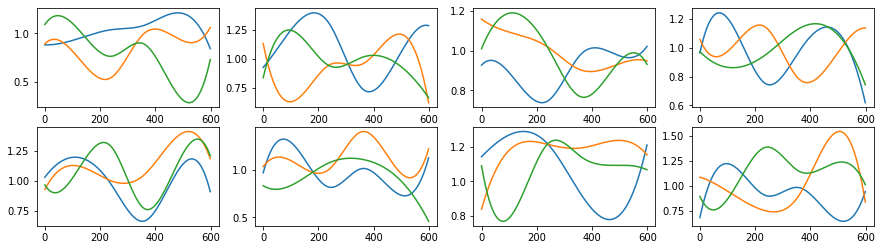

In [22]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(GenerateRandomCurves(data[0,:,:], sigma))

In [23]:
def DA_MagWarp(X, sigma):
    return X * GenerateRandomCurves(X, sigma)

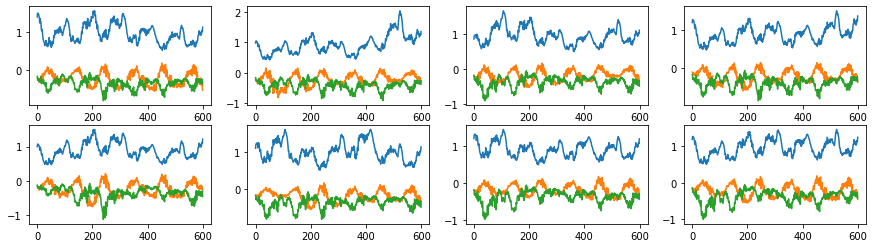

In [25]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_MagWarp(data[0,:,0:3], sigma))

## 4. Time Warping
Hyperparameters : sigma = STD of the random knots for generating curves  
knot = # of knots for the random curves (complexity of the curves)  

하이퍼 파라미터 : sigma = 곡선 생성을위한 임의 매듭의 STD  
knot = 무작위 곡선의 매듭 수 (곡선의 복잡성)

In [26]:
sigma = 0.2
knot = 4

In [27]:
def DistortTimesteps(X, sigma=0.2):
    tt = GenerateRandomCurves(X, sigma) # Regard these samples aroun 1 as time intervals
    tt_cum = np.cumsum(tt, axis=0)        # Add intervals to make a cumulative graph
    # Make the last value to have X.shape[0]
    t_scale = [(X.shape[0]-1)/tt_cum[-1,0],(X.shape[0]-1)/tt_cum[-1,1],(X.shape[0]-1)/tt_cum[-1,2]]
    tt_cum[:,0] = tt_cum[:,0]*t_scale[0]
    tt_cum[:,1] = tt_cum[:,1]*t_scale[1]
    tt_cum[:,2] = tt_cum[:,2]*t_scale[2]
    return tt_cum

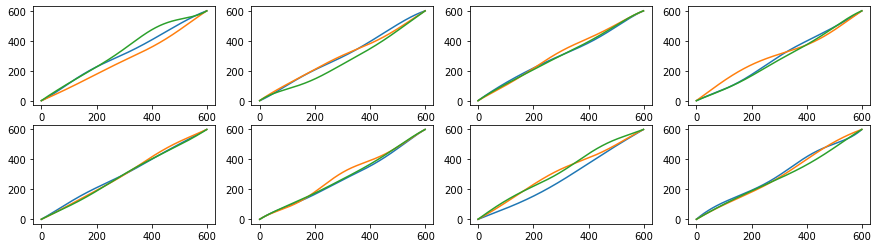

In [28]:
## Random curves around 1.0
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DistortTimesteps(data[0,:,:], sigma))

In [29]:
def DA_TimeWarp(X, sigma=0.2):
    tt_new = DistortTimesteps(X, sigma)
    X_new = np.zeros(X.shape)
    x_range = np.arange(X.shape[0])
    X_new[:,0] = np.interp(x_range, tt_new[:,0], X[:,0])
    X_new[:,1] = np.interp(x_range, tt_new[:,1], X[:,1])
    X_new[:,2] = np.interp(x_range, tt_new[:,2], X[:,2])
    return X_new

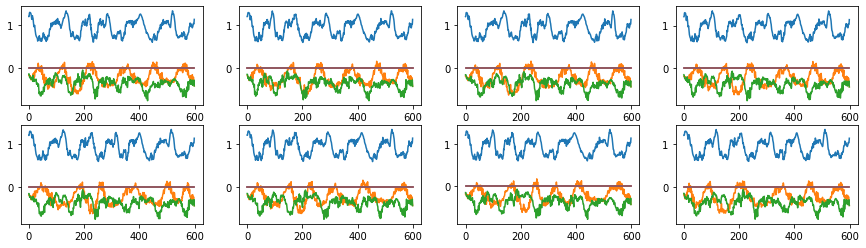

In [30]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_TimeWarp(data[0,:,:], sigma))

## 5. Rotation

In [31]:
def DA_Rotation(X):
    axis = np.random.uniform(low=-1, high=1, size=X.shape[1])
    angle = np.random.uniform(low=-np.pi, high=np.pi)
    return np.matmul(X , axangle2mat(axis,angle))

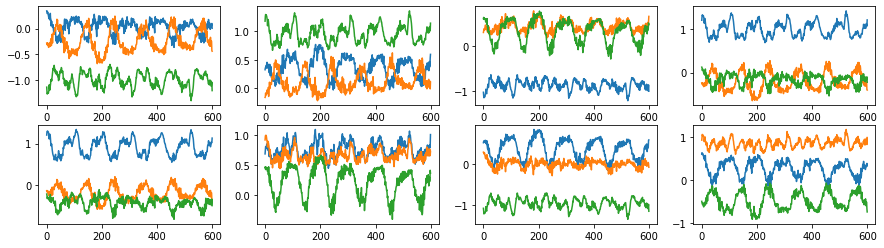

In [33]:

fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(data[0,:,0:3]))

## 6. Permutation
Hyperparameters : nPerm = # of segments to permute  
minSegLength = allowable minimum length for each segment  

하이퍼 파라미터 : nPerm = 순회 할 세그먼트 수  
minSegLength = 각 세그먼트에 허용되는 최소 길이

In [34]:
nPerm = 4
minSegLength = 100

In [35]:
def DA_Permutation(X, nPerm=4, minSegLength=10):
    X_new = np.zeros(X.shape)
    idx = np.random.permutation(nPerm)
    bWhile = True
    while bWhile == True:
        segs = np.zeros(nPerm+1, dtype=int)
        segs[1:-1] = np.sort(np.random.randint(minSegLength, X.shape[0]-minSegLength, nPerm-1))
        segs[-1] = X.shape[0]
        if np.min(segs[1:]-segs[0:-1]) > minSegLength:
            bWhile = False
    pp = 0
    for ii in range(nPerm):
        x_temp = X[segs[idx[ii]]:segs[idx[ii]+1],:]
        X_new[pp:pp+len(x_temp),:] = x_temp
        pp += len(x_temp)
    return(X_new)

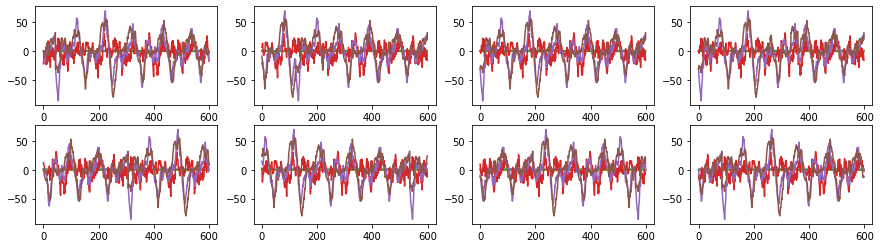

In [36]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Permutation(data[0,:,:]))

## 7. Random Sampling
Hyperparameters : nSample = # of subsamples (nSample <= X.shape[0])  
This approach is similar to TimeWarp, but will use only subsamples (not all samples) for interpolation. (Using TimeWarp is more recommended)  

하이퍼 파라미터 : nSample = 하위 샘플 수 (nSample <= X.shape [0])  
이 접근 방식은 TimeWarp와 유사하지만 보간에 하위 샘플 (모든 샘플이 아님) 만 사용합니다. (TimeWarp를 사용하는 것이 더 좋습니다)

In [42]:
nSample = 100

In [43]:
def RandSampleTimesteps(X, nSample=1000):
    X_new = np.zeros(X.shape)
    tt = np.zeros((nSample,X.shape[1]), dtype=int)
    tt[1:-1,0] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,1] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[1:-1,2] = np.sort(np.random.randint(1,X.shape[0]-1,nSample-2))
    tt[-1,:] = X.shape[0]-1
    return tt

In [44]:
def DA_RandSampling(X, nSample=1000):
    tt = RandSampleTimesteps(X, nSample)
    X_new = np.zeros(X.shape)
    X_new[:,0] = np.interp(np.arange(X.shape[0]), tt[:,0], X[tt[:,0],0])
    X_new[:,1] = np.interp(np.arange(X.shape[0]), tt[:,1], X[tt[:,1],1])
    X_new[:,2] = np.interp(np.arange(X.shape[0]), tt[:,2], X[tt[:,2],2])
    return X_new

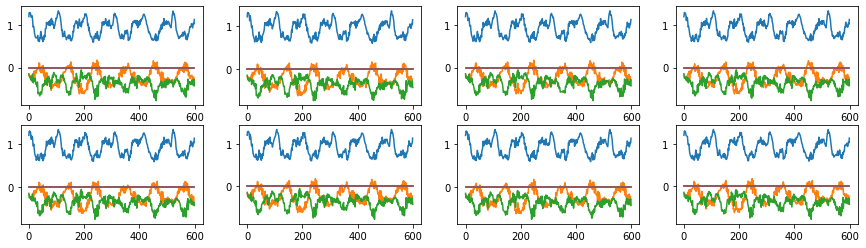

In [46]:
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_RandSampling(np.array(data[0,:,:]).reshape(600,-1)))

## 8. Combinations

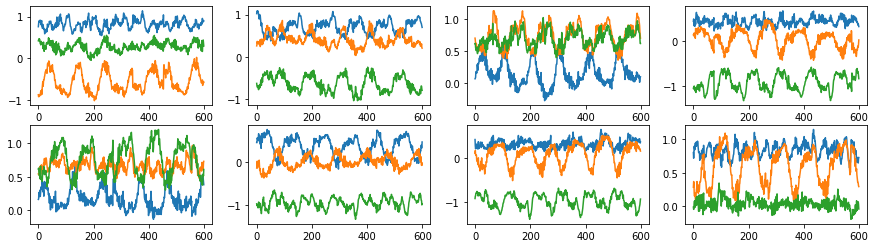

In [48]:
## Rotation + Permutation
fig = plt.figure(figsize=(15,4))
for ii in range(8):
    ax = fig.add_subplot(2,4,ii+1)
    ax.plot(DA_Rotation(DA_Permutation(data[0,:,0:3], nPerm=4)))

In [49]:
# https://github.com/terryum/Data-Augmentation-For-Wearable-Sensor-Data/blob/master/Example_DataAugmentation_TimeseriesData.ipynb